In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import requests
import warnings

from datetime import datetime
from dateutil.relativedelta import relativedelta
from time import sleep

# Plotting
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

In [2]:
# Import AAPL data
raw_data = pd.read_csv('./data/aapl_1y.csv', index_col='date')
raw_data.head()

,open,high,low,close,volume
date,,,,,
5/30/19,177.95,179.23,176.67,178.30,21218412
5/29/19,176.42,179.35,176.00,177.38,28481164
5/28/19,178.92,180.59,177.91,178.23,27948160
5/24/19,180.20,182.14,178.62,178.97,23714686
5/23/19,179.80,180.54,177.81,179.66,36529736


# Define Security Class
This class holds information for securities that will be used for PnF charting

In [3]:
class Security:
    def __init__(self, data, date_format='%Y-%m-%d'):
        self.data = data # Date-indexed OHLC data
        self._chart = None
        self._pnf_bars = None
        self._pnf_points = []
        self._pnf_columns = None
        self._default_format = '%Y-%m-%d'
        self.date_format = date_format
        
        # Ensure that index of data is of format %Y-%m-%d
        self.format_index()
        
    @property
    def data(self):
        return self._data
    
    @data.setter
    def data(self, d):
        # Ensure data has correct columns and date index
        required_cols = set(['close', 'high', 'low'])
        cols = set(d.columns)
        if len(required_cols.intersection(cols)) != len(required_cols):
            raise ValueError("Security data doesn't contain all required columns: ('close', 'high', 'low')")
        self._data = d
        #else:
            # Check index is of right dtype
            #required_type = pd._libs.tslib.Timestamp
            #if d.index.dtype != required_type:
            #    raise ValueError("Security data needs to have index values of type pd.Timestamp")
            #else:
                #self._data = d
                
    @property
    def pnf_points(self):
        return self._pnf_points
    
    @pnf_points.setter
    def pnf_points(self, p):
        if len(p) == 0:
            raise ValueError('List of PnF points can not be empty')
        if type(p[0]) != PnfPoint:
            raise ValueError('PnF points in list must be of type PnfPoint')
        self._pnf_points = p
        
    @property
    def chart(self):
        return self._chart
    
    @chart.setter
    def chart(self, c):
        if type(c) != Chart:
            raise ValueError('self._chart must be of type Chart')
        self._chart = c
        
    @property
    def pnf_bars(self):
        return self._pnf_bars
    
    @pnf_bars.setter
    def pnf_bars(self, pb):
        if type(pb) != pd.DataFrame:
            raise ValueError('self._pnf_bars must be a pd.DataFrame')
        self._pnf_bars = pb
        
    @property
    def pnf_columns(self):
        return self._pnf_columns
    
    @pnf_columns.setter
    def pnf_columns(self, c):
        if len(c) == 0:
            raise ValueError('self._pnf_columns cannot be empty')
        if type(c[0]) != PnfColumn:
            raise ValueError('self._pnf_columns must be a list of PnfColumn objects')
        self._pnf_columns = c
        
    @property
    def date_format(self):
        return self._date_format
    
    @date_format.setter
    def date_format(self, df):
        if type(df) != str:
            raise ValueError('self.date_format must be a date format string')
        self._date_format = df
        
    def format_index(self):
        '''
            Formats self._data index so that it is in format %Y-%m-%d
        '''
        idx = pd.Series(self.data.index)
        idx = idx.apply(lambda d: datetime.strptime(d, self.date_format))
        idx = idx.apply(lambda d: datetime.strftime(d, '%Y-%m-%d'))
        self.data.index = idx
        
    def generate_pnf_data(self, method='trad'):
        '''
            Generates PnF data necessary for plotting/bar creation
        '''
        # Create chart instance
        self.chart = Chart(self.data)
        # Get PnfPoints
        self.chart.generate_pnf_points(scaling=method)
        self.pnf_points = self.chart.pnf_points
        # Get Pnf Columns
        self.chart.generate_pnf_columns()
        self.pnf_columns = self.chart.columns
        
    def plot_chart(self):
        '''
            Generates a PnF Chart
        '''
        if self.chart == None:
            raise ValueError('Chart not instantiated. Please call self.generate_pnf_data before \
            calling self.plot_chart')
        else:
            self.chart.plot_chart()
        
    def generate_pnf_bars(self):
        '''
            Generates PnF bars using self._pnf_points
            
            Args:
                None
                
            Returns:
                (pd.DataFrame): dataframe of PnF bars
        '''
        # Generate rough dataframe from _pnf_points
        pnf_df = pd.DataFrame()
        for p in self.pnf_points:
            pnf_df = pnf_df.append(pd.DataFrame.from_dict({
                'date': [p.date],
                'direction': [p.direction],
                'value': [p.value],
                'double_top': [p.signals['double_top']],
                'double_bottom': [p.signals['double_bottom']],
                'triple_top_break': [p.signals['triple_top_break']],
                'triple_bottom_break': [p.signals['triple_bottom_break']],
            }))
        
        pnf_df = pnf_df.reset_index().drop(['index'], axis=1)
        
        # Find time between ticks
        pnf_df['date'] = pnf_df.date.apply(lambda d: datetime.strptime(d, self._default_format))
        pnf_df['timedelta'] = pnf_df.date - pnf_df.date.shift(1)
        
        # Change index to date
        pnf_df = pnf_df.set_index('date')
        pnf_df.dropna(inplace=True)
        
        # Aggregate data so only one bar per day
        dates = pnf_df.index.unique()
        agg_df = pd.DataFrame()
        for date in dates:
            # Get all bars for this date
            date_df = pnf_df.loc[[date]]
            # Get attributes
            direction = date_df.iloc[0].direction
            timedelta = np.max(date_df.timedelta)
            # Get signals
            double_top = True in date_df['double_top'].values
            double_bottom = True in date_df['double_bottom'].values
            triple_top_break = True in date_df['triple_top_break'].values
            triple_bottom_break = True in date_df['triple_bottom_break'].values
            # Get signals
            if direction == 'x':
                value = np.max(date_df.value)
            else:
                value = np.min(date_df.value)

            # Append aggregated row to df
            agg_df = agg_df.append(pd.DataFrame.from_dict({
                'value': [value],
                'direction': [direction],
                'timedelta': [timedelta],
                'double_top': [double_top],
                'double_bottom': [double_bottom],
                'triple_top_break': [triple_top_break],
                'triple_bottom_break': [triple_bottom_break],
                'date': [date]
            }))

        agg_df = agg_df.set_index('date')
        self.pnf_bars = agg_df
        
    def get_pnf_signals(self):
        '''
            Will identify pnf buy/sell signals and append these signal occurrences
            to pnf points on the day they occurred
        '''
        # Create pattern finder using pnf columns
        pf = PatternFinder(self.pnf_columns)
        # Identify all signals using pattern finder
        pf.identify_all_signals()
        # Set points back to security
        self.pnf_points = pf.pnf_points
        
    def is_on_buy(self):
        '''
            Returns True if pnf chart is currently on a buy signal, false otherwise
        '''
        # Iterate through pnf points from end -> beginning and find most recent signal.
        # If it is a buy, return true, if it is a sell or no signal, return False
        for p in self.pnf_points[::-1]:
            buy_signal = p.signals['double_top']
            sell_signal = p.signals['double_bottom']
            # Return True if on a buy signal, False if on a sell signal
            if buy_signal:
                return True
            if sell_signal:
                return False            
        # If we iterate through all points and there are no signals, return False
        return False
            
            

# Define PnfPoint Class
This class represents the data for a point on our PnF chart

In [4]:
class PnfPoint:
    def __init__(self, direction, value, date, marker):
        self.direction = direction
        self.value = value
        self.date = date
        self.marker = marker
        self.signals = {
            'double_top': False,
            'double_bottom': False,
            'triple_top_break': False,
            'triple_bottom_break': False,
        }
        
    def __str__(self):
        '''
            Overloaded print function
        '''
        return 'Date: {} | Value: {} | Dir: {} |  Signals: {}'.format(self.date, 
                                                                      self.value, 
                                                                      self.direction,
                                                                      self.signals)
        
    @property
    def direction(self):
        return self._direction
    
    @direction.setter
    def direction(self, d):
        self._direction = d
        
    @property
    def value(self):
        return self._value
    
    @value.setter
    def value(self, v):
        self._value = v
        
    @property
    def date(self):
        return self._date
    @date.setter
    def date(self, d):
        self._date = d
        
    @property
    def marker(self):
        return self._marker    
    @marker.setter
    def marker(self, m):
        self._marker = m
        
    @property
    def signals(self):
        return self._signals
    @signals.setter
    def signals(self, s):
        if type(s) != dict:
            raise ValueError('self.signals must be of type dict with the signal name as the key ' +
                            'and a bool as the value.')
        self._signals = s
    

# Define a Column Class
This will hold a set of points corresponding to a column on a PnfChart

In [5]:
class PnfColumn:
    def __init__(self, points, direction):
        self.pnf_points = points
        self.direction = direction
        
    @property
    def pnf_points(self):
        return self._pnf_points
    
    @pnf_points.setter
    def pnf_points(self, points):
        if len(points) == 0:
            raise ValueError('self._pnf_points cannot be empty')
        if type(points[0]) != PnfPoint:
            raise ValueError('self._pnf_points must be an iterable with elements of type PnfPoint')
        
        # May want to enforce some sorting here
        self._pnf_points = points    
        
    @property
    def direction(self):
        return self._direction
    
    @direction.setter
    def direction(self, d):
        if type(d) != str:
            raise ValueError('self._direction must be a string')
        if d.lower() not in ['x', 'o']:
            raise ValueError('self._direction must be either "x" or "o"')
        self._direction = d
        
    def max(self):
        '''
            Iterate through all points in column and find one with highest value
        '''
        max_val = 0
        for p in self._pnf_points:
            if p._value > max_val:
                max_val = p._value
        return max_val
    
    def min(self):
        '''
            Iterate through all points in column and find one with the lowest value
        '''
        min_val = 1e9
        for p in self._pnf_points:
            if p._value < min_val:
                min_val = p._value
        return min_val

# Define a Chart Class
This class will be used to calculate and plot the PnF events for a given security

In [6]:
class Chart:
    def __init__(self, data):
        self.data = data
        self._pnf_points = []
        self._columns = []
        self._boxes = []
        self.scale_methods = ['trad', 'pct']
        
    @property
    def data(self):
        return self._data    
    @data.setter
    def data(self, d):
        # Ensure data has correct columns and date index
        required_cols = set(['close', 'high', 'low'])
        cols = set(d.columns)
        if len(required_cols.intersection(cols)) != len(required_cols):
            raise ValueError("Security data doesn't contain all required columns: ('close', 'high', 'low')")
        else:
            # Check index is of right dtype
            required_type = pd._libs.tslib.Timestamp
            if d.index.dtype != required_type:
                raise ValueError("Security data needs to have index values of type pd.Timestamp")
            else:
                self._data = d
    
    @property
    def pnf_points(self):
        return self._pnf_points    
    @pnf_points.setter
    def pnf_points(self, p):
        if len(p) == 0:
            raise ValueError('List of PnF points can not be empty')
        if type(p[0]) != PnfPoint:
            raise ValueError('PnF points in list must be of type PnfPoint')
        self._pnf_points = p
        
    @property
    def columns(self):
        return self._columns    
    @columns.setter
    def columns(self, c):
        if len(c) == 0:
            raise ValueError('PnF Columns cannot be empty')
        if not type(c[0]) != PnfColumn:
            raise ValueError('Columns must be of type PnfColumn')
        self._columns = c
        
    @property
    def boxes(self):
        return self._boxes    
    @boxes.setter
    def boxes(self, b):
        if type(b) != pd.Series:
            raise ValueError('self._boxes must be of type pd.Series')
        self._boxes = b
        
    @property
    def scale_methods(self):
        return self._scale_methods
    @scale_methods.setter
    def scale_methods(self, sm):
        # Check that sm is list
        if type(sm) != list:
            raise ValueError('self.scale_methods must be of type list')
        # Check that sm isn't empty
        if len(sm) == 0:
            raise ValueError('self.scale_methods cannot be empty.')
        # Check that sm values are strings
        for elt in sm:
            if type(elt) != str:
                raise ValueError('self.scale_methods must contain elements of type str')
        self._scale_methods = sm
        
        
    def get_trad_box_increment(self, value):
        '''
            Gets the box size for traditional box sizing method
            
            Args:
                value (numeric): the value whose increment we are returning
                
            Returns:
                (numeric): a box increment value dependent upon input value
        '''

        scale_dict = {
        0: 0.0625,
        0.25: 0.125,
        1: 0.25,
        5: 0.5,
        20: 1.0,
        100: 2.0,
        200: 4.0,
        500: 5.0,
        1000: 50.0,
        25000: 500.0
    }
        # Get possible ranges
        ranges = sorted(list(scale_dict.keys()))
        # Find price range
        scale_key = 1
        for r in ranges:
            if value >= r:
                scale_key = r
            else:
                break

        return scale_dict[scale_key]
        
        
    def generate_boxes(self, value=0, method='trad'):
        '''
            Generate a series of values representing the boxes of a pnf chart.
            
            Args:
                value (numeric): value around which to generate box sizes (optional for 
                                    'trad' scaling method)
                method (str): the scaling method to use. See self.valid_methods
                
            Returns:
                None. Sets self._boxes to a pd.Series
        '''
        # Ensure that method is valid
        if method not in self.scale_methods:
            raise ValueError('Unknown scaling method passed. Options are: {}'.format(self._scale_methods))
            
        # If method is traditional, then boxes will always be the same. Generate them
        # up to 100000
        max_val = 100000
        boxes = []
        if method == 'trad':
            boxes.append(0)
            while boxes[-1] < max_val:
                inc = self.get_trad_box_increment(boxes[-1])
                boxes.append(boxes[-1] + inc)
                
        #If method is percentage, then we will generate 100 boxes above and below the value
        if method == 'pct':
            boxes_to_gen = 200
            boxes = [round(0.01 * ii * value, 2) for ii in range(boxes_to_gen)]
                
        # Set boxes
        self.boxes = pd.Series(boxes)
    
    def get_box_diff(self, val, prev_val, direction):
        '''
            Get the box difference between val and prev_val
            
            Args:
                val (numeric): the current value during pnf generation
                prev_val (numeric): the previous value plotted on the pnf chart
                direction (char, 'x' or 'o'): are we checking box differences for 
                            column of Xs or Os?
                
            Returns:
                (numeric): the number of boxes val has moved from prev_val
        '''
        
        
        if direction == 'x':
            # If determining Xs, need to look at boxes below
            prev_boxes = len(self.boxes[self.boxes <= prev_val])
            val_boxes = len(self.boxes[self.boxes <= val])
        else:
            # If determining Os, need to find boxes above
            prev_boxes = len(self.boxes[self.boxes >= prev_val])
            val_boxes = len(self.boxes[self.boxes >= val])
        
        # Get difference
        return val_boxes - prev_boxes
        
    
    def generate_pnf_points(self, scaling='trad'):
        '''
            Generate the PnF events for the chart's associated security
            
            Args: 
                scaling (str): method used to determine box sizes (see self.get_scale)
            
            Returns:
                Nothing. Events stored in self._pnf_points
                
        '''
        #print('Length of chart dataset: {}'.format(len(self._data)))
        # Use first close as starting point
        self.prev_val = self.data.close[0]
        
        # If using 'trad' scaling method, get boxes now as they are fixed
        if scaling == 'trad':
            self.generate_boxes(method='trad')

        # Is the current column an X or O?
        col_is_x = False
        col_is_o = False
        
        # Iterate through data and calculate pnf events
        for ii, row in self.data.iterrows():
            # Skip the first day
            if(ii == self.data.index[0]):
                continue
                
            # For percentage based method, calculate boxes each iteration
            if scaling == 'pct':
                self.generate_boxes(value=self.prev_val, method='pct')
                
            # Get daily high and low
            high = row.high
            low = row.low
            
            # Find number of boxes between last box price and current
            # highs and lows. We will be concerned with positive difference
            # for X columns and negative differences for O columns
            high_box_diff = self.get_box_diff(high, self.prev_val, direction='x')
            low_box_diff = self.get_box_diff(low, self.prev_val, direction='o')
            
            # Determine how many boxes of movement are needed to add an X or O
            x_thresh = 1 if col_is_x else 3
            o_thresh = 1 if col_is_o else 3
            
            # Check edge case to see if both boxes broke their thresholds
            if high_box_diff >= x_thresh and low_box_diff >= o_thresh:
                # Check current column, and give priority to current symbol
                if col_is_x:
                    self.append_pnf_point('x', high_box_diff, date=ii)
                    col_is_x, col_is_o = True, False
                else:
                    self.append_pnf_point('o', low_box_diff, date=ii)
                    col_is_o, col_is_x = True, False
            else:
                # If only one threshold broken, determine which one (if any) and append accordingly.
                if high_box_diff >= x_thresh:
                    self.append_pnf_point('x', high_box_diff, date=ii)
                    col_is_x, col_is_o = True, False

                if low_box_diff >= o_thresh:
                    self.append_pnf_point('o', low_box_diff, date=ii)
                    col_is_o, col_is_x = True, False
                    
            # Set last value
            if len(self.pnf_points) > 0:
                self.prev_val = self.pnf_points[-1].value
    
    def append_pnf_point(self, direction, diff, date):
        '''
            Append a new PnF point to self._pnf_points
            
            Args:
                direction (char): 'x' or 'o' -- direction of PnF Chart
                diff (int): number of boxes we've moved
                date (pd.Timestamp): date point was added to chart
                
            Returns:
                Nothing. New points are appended to self._pnf_points
        '''
        # Get index of previously charted box
        val_box_idx = self.boxes[self.boxes <= self.prev_val].idxmax()
        # Get date of previously charted value
        prev_date = self.pnf_points[-1].date if len(self.pnf_points) > 0 else None
        prev_month = datetime.strptime(prev_date, '%Y-%m-%d').month if prev_date != None else None
        app_seq = []
        for ii in range(1, diff+1):
            # Determine if we are moving up or down boxes
            box_dir = 1 if direction == 'x' else -1
            value = self.boxes[val_box_idx + (ii * box_dir)]
            # Determine what marker will be used to plot. If this is the first
            # plotted point of a month, we will use a special marker
            if datetime.strptime(date, '%Y-%m-%d').month != prev_month:
                marker = '^'
                prev_month = datetime.strptime(date, '%Y-%m-%d').month
            else:
                marker = direction
            # Create point
            point = PnfPoint(direction, value, date, marker)
            # Append point to sequence
            app_seq.append(point)

        # Append these PnF Points to chart's list
        if len(self.pnf_points) > 0:
            self.pnf_points += app_seq
        else:
            self.pnf_points = app_seq      
            
    def generate_pnf_columns(self):
        '''
            Take the points contained in self._pnf_points and generate the columns
            of the corresponding PnF chart
            
            Args:
                None
            
            Returns:
                None. Columns saved to self._columns
        '''
        prev_dir = ''
        column_points = []
        for ii, point in enumerate(self.pnf_points):
            # X or O?
            curr_dir = point.direction
            # If same as prev symbol, append to curr column
            if curr_dir == prev_dir:
                column_points[-1].append(point)
            else:
                # New column
                prev_dir = curr_dir
                column_points.append([point])
                
        # Once we have the points for each column, make PnfColumn objects
        for col in column_points:
            pnf_col = PnfColumn(points=col, direction=col[0].direction)
            self.columns.append(pnf_col)
                
    def plot_chart(self):
        '''
            Plot the PnF Chart
        '''
        fig = plt.figure(1, figsize=(20, 10))
        ax = fig.add_subplot(111)
        for ii, col in enumerate(self.columns):
            # Plot each point in column
            for p in col.pnf_points:
                y = p.value
                x = ii+1
                direction = p.direction
                marker = p.marker
                # Make month transitions blue
                if marker == '^':
                    color = 'blue'
                else:
                    color = 'black' if direction == 'x' else 'red'
                # Plot points
                plt.scatter(x, y, color=color, marker=marker)


        # Set Y range for plot
        #low = int(np.min([p.price for l in self._columns for p in l]))
        #high = int(np.max([p.price for l in self._columns for p in l]))
        plt.grid(True)
        plt.show()

# Instantiate Security and Generate PnF Data

In [7]:
sec = Security(raw_data[::-1], date_format='%m/%d/%y')
sec.generate_pnf_data(method='trad')

# Use PnF Data to Make PnF Chart

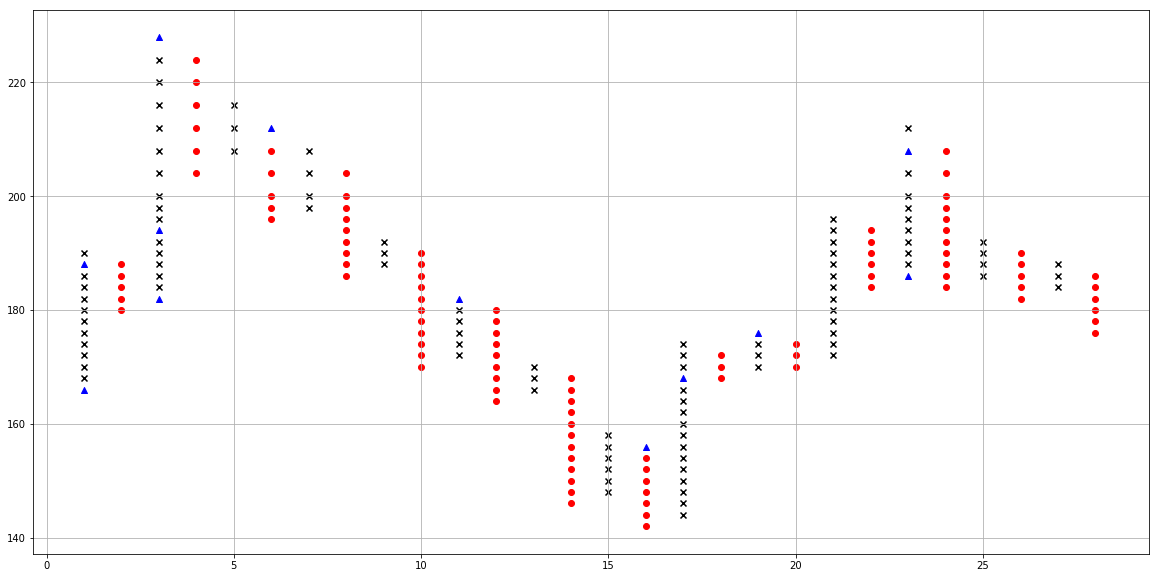

In [8]:
sec.plot_chart()

# Identify Buy/Sell Signals
We will create a class called PatternFinder which will be passed a list of lists of PnfPoints (chart columns) that can be used to identify common chart patterns.

In [9]:
class PatternFinder():
    def __init__(self, pnf_columns):
        self.columns = pnf_columns
        self._pnf_points = None
        
    @property
    def columns(self):
        return self._columns    
    @columns.setter
    def columns(self, c):
        if len(c) == 0:
            raise ValueError('self._columns cannot be empty.')
        if type(c[0]) != PnfColumn:
            raise ValueError('self._columns must be a list of PnfColumn objects')            
        self._columns = c
        
    @property
    def pnf_points(self):
        return self._pnf_points    
    @pnf_points.setter
    def pnf_points(self, p):
        if len(p) == 0:
            raise ValueError('self._pnf_points cannot be empty.')
        if type(p[0]) != PnfPoint:
            raise ValueError('self._pnf_points must contain elements of type PnfPoint')
        self._pnf_points = p
        
        
    def point_from_cols(self):
        '''
            This will iterate through self._columns and will place each point into
            self._pnf_points
        '''
        points = []        
        for col in self.columns:
            for p in col.pnf_points:
                points.append(p)                
        self._pnf_points = points
        
        
    def double_top_break(self):
        '''
            Identify where double top breaks occur (if at all) in the dataset. A double
            top breakout occurs when the current column of Xs exceeds the previous column
            of Xs 
            
            Returns:
                None. Appends double_top_break feature to PnfPoint._signals
        '''
        # Start by identifying all X columns
        x_col_idxs = []
        for ii, col in enumerate(self.columns):
            if col.direction == 'x':
                x_col_idxs.append(ii)
        
        # Find all successive pairs of X columns
        x_pairs = []
        for ii, idx in enumerate(x_col_idxs):
            # Break if we are at the last element and can't make a new pair
            if ii == len(x_col_idxs) - 1:
                break            
            # Create pairs
            x_pairs.append((x_col_idxs[ii], x_col_idxs[ii+1]))
            
        # Go through all pairs. If the second column in the pair has a higher max
        # than the first, this is a double top breakout
        for pair in x_pairs:
            col1 = self.columns[pair[0]]
            col2 = self.columns[pair[1]]
            
            if col2.max() > col1.max():
                # We have identified that a breakout has occurred in col2. Now
                # we must find the point responsible.
                for p in self.columns[pair[1]].pnf_points:
                    if p.value > col1.max():
                        p.signals['double_top'] = True
                        break
                
    def double_bottom_break(self):
        '''
            A double bottom breakdown occurs when a column of Os dips lower than the previous
            column of Os
            
            Returns:
                None. Appends double_bottom key/value to PnfPoint._signals
        '''
        # First identify all O columns
        o_col_idxs = []
        for ii, col in enumerate(self.columns):
            if col.direction == 'o':
                o_col_idxs.append(ii)
                
        # Find all successive pairs of O columns
        o_pairs = []
        for ii, idx in enumerate(o_col_idxs):
            # Break if we don't have enough remaining points to create a pair
            if ii == len(o_col_idxs) - 1:
                break
            # Create pairs
            o_pairs.append((o_col_idxs[ii], o_col_idxs[ii+1]))
            
        # Go through all pairs. If the second column in the pair has a lower
        # min than the first column, this is a double bottom breakdown
        for pair in o_pairs:
            col1 = self.columns[pair[0]]
            col2 = self.columns[pair[1]]
            
            if col2.min() < col1.min():
                # We've identified a double bottom breakdown in this column. Now
                # we must find the point responsible
                for p in self.columns[pair[1]].pnf_points:
                    if p.value < col1.min():
                        p.signals['double_bottom'] = True
                        break
                
    def triple_top_break(self):
        '''
            A triple top breakout occurs when the chart reaches a certain X column level twice,
            before breaking through that level on the third column of Xs
            
            Returns:
                None. Appends triple_top_break key/value pair to PnfPoint._signals
        '''
        # From columns get all X columns
        x_col_idxs = []
        for ii, col in enumerate(self.columns):
            if col.direction == 'x':
                x_col_idxs.append(ii)
                
        # Create triplets of all successive x columns
        x_triplets = []
        for ii, idx in enumerate(x_col_idxs):
            # If we don't have enough remaining indices to make a triplet, break
            if ii >= len(x_col_idxs) - 2:
                break
            # Create triplet
            try:
                triplet = (idx, x_col_idxs[ii+1], x_col_idxs[ii+2])
                x_triplets.append(triplet)
            except:
                raise ValueError('ERROR: ii: {} | x_cols: {}'.format(ii, len(x_col_idxs)))
            
        # Check that first two in triplet hit same level, if they did, and third col
        # breaks that level, this is a triple top breakout
        for triplet in x_triplets:
            # Get Columns
            col1 = self.columns[triplet[0]]
            col2 = self.columns[triplet[1]]
            col3 = self.columns[triplet[2]]
            
            # First two cols hit same level
            if col1.max() == col2.max():
                # Col 3 exceeds two column level
                if col3.max() > col1.max():
                    # We know that a triple top break has occurred in 
                    # this column, now we must find the point responsible
                    for p in self.columns[triplet[2]].pnf_points:
                        if p.value > col1.max():
                            p.signals['triple_top_break'] = True
                            break
                            
    def triple_bottom_break(self):
        '''
            A triple bottom break occurs when two successive columns of Os dip down to the same
            level, and the next column of Os breaks through that level.
            
            Returns:
            None. Appends triple_bottom_break key/value pair to PnfPoint._signals
        '''
        # First we identify all O columns
        o_col_idxs = []
        for ii, col in enumerate(self.columns):
            if col.direction == 'o':
                o_col_idxs.append(ii)
                
        # Next we create a triplet of all successive 3 O columns
        triplets = []
        for ii, idx in enumerate(o_col_idxs):
            # Break if we are at end of idxs and can't create another triplet
            if ii >= len(o_col_idxs) - 2:
                break
            # Create triplets
            try:
                triplet = (o_col_idxs[ii], o_col_idxs[ii+1], o_col_idxs[ii+2])
                triplets.append(triplet)
            except:
                raise ValueError('ERROR: ii: {} | o_cols: {}'.format(ii, len(o_col_idxs)))
            
        # Go through all triplets. If first two cols in triplet have same min level, and
        # third col has a lower level, this is a triple bottom breakdown
        for triplet in triplets:
            col1 = self.columns[triplet[0]]
            col2 = self.columns[triplet[1]]
            col3 = self.columns[triplet[2]]
            
            # First two cols have same min value
            if col1.min() == col2.min():
                # Third column breaks through min
                if col3.min() < col1.min():
                    # We have identified a triple bottom break in this column.
                    # Now we must find the point responsible
                    for p in self.columns[triplet[2]].pnf_points:
                        if p.value < col1.min():
                            p.signals['triple_bottom_break'] = True
                            break
                            
                            
    def identify_all_signals(self):
        '''
            Identify all supported buy/sell signals
        '''
        self.double_top_break()
        self.double_bottom_break()
        self.triple_top_break()
        self.triple_bottom_break()
        self.point_from_cols()
                

In [10]:
# Utilize pattern finder to get all buy/sell signals
sec.get_pnf_signals()

# Use PnF Data to Generate Bars

In [11]:
sec.generate_pnf_bars()
sec.pnf_bars.head(15)
sec.pnf_bars.iloc[-25:]

,direction,double_bottom,double_top,timedelta,triple_bottom_break,triple_top_break,value
date,,,,,,,
2019-03-12,x,False,False,1 days,False,False,180.0
2019-03-13,x,False,False,1 days,False,False,182.0
2019-03-15,x,False,False,2 days,False,False,186.0
2019-03-19,x,False,False,4 days,False,False,188.0
2019-03-21,x,False,False,2 days,False,False,194.0
2019-03-22,x,False,False,1 days,False,False,196.0
2019-03-25,o,False,False,3 days,False,False,186.0
2019-03-26,o,False,False,1 days,False,False,184.0
2019-04-01,x,False,False,6 days,False,False,190.0


In [12]:
sec.is_on_buy()

False

# Define a Relative Strength Class
This class will be able to do all relevant RS calculations between two assets

In [13]:
class RSInstrument(Security):
    def __init__(self, num, den, date_format='%Y-%m-%d'):
        # Set numerator and denominator of RS Calc
        self.num_sec = num 
        self.den_sec = den 
        # Create the combined dataset by dividing metrics from numerator
        # by the metrics of the denominator
        self.get_rs_data()
        # Initialize security using the quotient data
        Security.__init__(self, self.data, date_format=date_format)
        
    @property
    def num_sec(self):
        return self._num_sec    
    @num_sec.setter
    def num_sec(self, ns):
        if type(ns) != pd.DataFrame:
            raise ValueError('self._num_sec must be of type pd.DataFrame')
        self._num_sec = ns
        
    @property
    def den_sec(self):
        return self._den_sec    
    @den_sec.setter
    def den_sec(self, ds):
        if type(ds) != pd.DataFrame:
            raise ValueError('self._den_sec must be of type pd.DataFrame')            
        self._den_sec = ds
        
    def in_col_x(self):
        '''
            Returns true if the RS Chart is in a column of Xs
        '''
        if self.pnf_columns == None or len(self.pnf_columns) == 0:
            #raise ValueError('self.pnf_columns is not instantiated. Have you run self.generate_pnf_data()?')
            return False
        return self.pnf_columns[-1].direction ==  'x'
        
    def get_rs_data(self):
        '''
            Take data from numerator and divide by data in denominator to get the data
            required to create the RS chart
        '''
        # Do some sort of index checking here to ensure that data actually occurs during
        # the same time frame
        combined_idx = self.num_sec.index.union(self.den_sec.index)
        data = self.num_sec.join(self.den_sec, lsuffix='_num', rsuffix='_den')
        
        # Back fill to account for any times when either the num/den did not have data
        data.fillna(method='bfill', inplace=True)
        
        # Get the quotient data --  divide numerator values by denominator closes
        data['open'] = data['open_num'] / data['close_den']
        data['high'] = data['high_num'] / data['close_den']
        data['low'] = data['low_num'] / data['close_den']
        data['close'] = data['close_num'] / data['close_den']
        data['volume'] = data['volume_num'] / data['volume_den']
        
        # Multiply all quotients by 100 to get percentage points instead of decimals
        self.data = data[['open', 'high', 'low', 'close', 'volume']]
        self.data *= 100.

In [14]:
def load_stockcharts_csv(filename):
    '''
        Loads data ripped from StockCharts historical data
    '''
    # Read in file
    df = pd.read_csv(filename, index_col='Date')
    # Convert columns to lowercase
    df.columns = [c.lower() for c in df.columns]
    # Drop day column
    df = df.drop(['day'], axis=1)
    # Drop 1st row -- it is just a horizontal line of ===
    df = df.iloc[1:]
    # Convert all columns to numeric
    for col in df.columns:
        df[col] = df[col].apply(lambda x: float(x))
    # Reverse to have oldest data first
    df = df.loc[::-1]
    return df

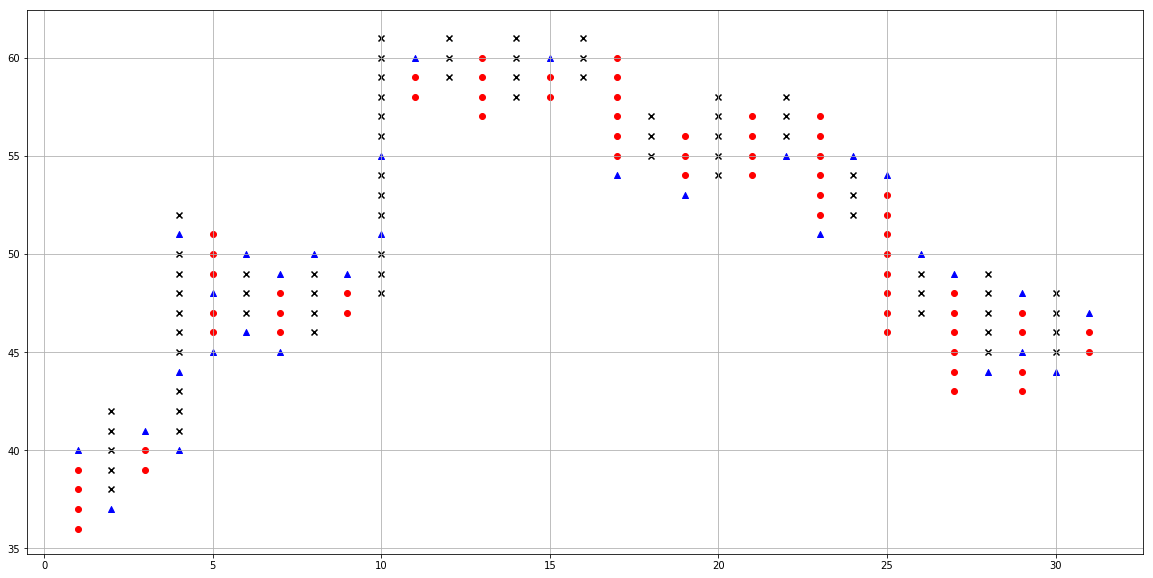

In [15]:
xlf_df = load_stockcharts_csv('./data/sector/xlf_3y.csv')
xlu_df = load_stockcharts_csv('./data/sector/xlu_3y.csv')
rsi = RSInstrument(num=xlf_df, den=xlu_df, date_format='%m/%d/%y')
rsi.generate_pnf_data()
rsi.plot_chart()

# Create an RS Matrix Class
This class will be instantiated with data from at least 2 tickers and then generate an RS matrix using those tickers. 

In [16]:
class RSMatrix:
    def __init__(self, ticker_dict):
        self.ticker_dict = ticker_dict
        self.pattern_finder = None
        
    @property
    def ticker_dict(self):
        return self._ticker_dict    
    @ticker_dict.setter
    def ticker_dict(self, td):
        # Check that td is a dictionary
        if type(td) != dict:
            raise ValueError('self._ticker_dict must be a dictionary')
        # Check that td has at least two tickers
        if len(list(td.keys())) < 2:
            raise ValueError('self._ticker_dict must have at least two tickers worth of data')
        # Check that values of td are pd.DataFrames
        for k,v in td.items():
            if type(v) != pd.DataFrame:
                raise ValueError('Values of self._ticker_dict must be of type pd.DataFrame')
        self._ticker_dict = td
        
    @property
    def matrix(self):
        return self._matrix
    
    @matrix.setter
    def matrix(self, m):
        if type(m) != pd.DataFrame:
            raise ValueError('self.matrix must be of type pd.DataFrame')
        self._matrix = m
        
    def generate_matrix(self, date_format='%m/%d/%y'):
        '''
            Create RS matrix using tickers/data in self.ticker_dict
        '''
        # Matrix is going to be a pandas dataframe whose index is all of the tickers in
        # ticker_dict and whose columns are the tickers in ticker_dict plus additional columns
        # for buy signal count and X column count
        idx = list(self.ticker_dict.keys())
        columns = ['buy_count', 'x_count'] + idx[::-1]
        self.matrix = pd.DataFrame(columns=columns, index=idx)
        self.matrix['buy_count'] = pd.Series(0, index=self.matrix.index)
        self.matrix['x_count'] = pd.Series(0, index=self.matrix.index)
        
        
        # For each pair of tickers create an RSInstrument 
        self.rsi_dict = {}
        curr_item = 0
        total_items = len(list(self.ticker_dict.keys())) ** 2
        for kn,vn in self.ticker_dict.items(): # Numerator symbols
            for kd,vd in self.ticker_dict.items(): # Den symbols
                # Progress
                curr_item += 1
                print('Calculating Matrix Element {}/{}'.format(str(curr_item), str(total_items)),
                     end='\r', flush=True)
                # Don't compare to self
                if kn == kd:
                    self.matrix.loc[kn, kd] = '--'
                else:
                    # Create RSInstrument using symbols
                    rsi = RSInstrument(num=vn, den=vd, date_format=date_format)
                    rsi.generate_pnf_data(method='trad')
                    # Determine if RS Chart is on buy or sell signal
                    rsi.get_pnf_signals()
                    if rsi.is_on_buy():
                        entry = 'B'
                        self.matrix.loc[kn, 'buy_count'] += 1
                    else:
                        entry = 'S'                    
                    # Determine if RS Chart in column of Xs or Os
                    if rsi.in_col_x():
                        entry += 'X'
                        self.matrix.loc[kn, 'x_count'] += 1
                    else:
                        entry += 'O'
                        
                    # If there is no pnf_data, then put --
                    if len(rsi.pnf_points) == 0:
                        entry = '--'
                    
                    # Add entry to RS matrix
                    self.matrix.loc[kn, kd] = entry
                    
    def show(self):
        '''
            Prints out the RS Matrix in a plotly table
        '''
        # Add ticker column to matrix
        self.matrix['ticker'] = pd.Series(list(self.matrix.index), index=self.matrix.index)
        self.matrix['ticker'] = self.matrix.ticker.apply(lambda x: '<b>{}</b>'.format(x.upper()))
        col_order = ['ticker'] + [c for c in self.matrix.columns if c != 'ticker']
        self.matrix = self.matrix[col_order]
        # Determine colors for each cell
        cell_colors = []
        for c in self.matrix.columns:
            col_colors = []
            # If this is the buy_count or x_count col, set color to grey
            if c in ['buy_count', 'x_count']:
                col_colors = ['grey' for cell in self.matrix[c]]
            elif c == 'ticker':
                col_colors = ['white' for cell in self.matrix[c]]
            else:
                # If on buy signal, make color green, if on sell make red. If 
                # this is self:self cell, make white.
                for cell in self.matrix[c]:
                    if cell == '--':
                        col_colors.append('white')
                    elif 'B' in cell:
                        col_colors.append('green')                    
                    else:
                        col_colors.append('red')
            cell_colors.append(col_colors)
                    
        
        trace = go.Table(
            header = dict(
                values = ['<b>{}</b>'.format(c.upper()) for c in self.matrix.columns],
                line = dict(color=['black']),
                fill = dict(color='white'),
                align = 'center',
                font = dict(color = ['white','black'] , size=16)
            ),
            cells = dict(
                values = [self.matrix[c] for c in self.matrix.columns],
                line = dict(color = 'black'),
                fill = dict(color = cell_colors),
                align = 'center',
                font = dict(color = ['black','white'], size = 16),
                height = 30
            )
        )
        
        # Set table data
        table_data = [trace]        
        # Plot data
        py.iplot(table_data)
        
        # Drop ticker column
        self.matrix = self.matrix.drop(['ticker'], axis=1)
        

# Create Sector RS Matrix
Using the SP500 Sector ETFs, create a basic RS matrix showing the relative strength between each sector.

In [ ]:
# Initialize all sector ETF dataframes
root = './data/sector/'
spy_df = load_stockcharts_csv(root + 'spy_3y.csv') # S&P 500
xlb_df = load_stockcharts_csv(root + 'xlb_3y.csv') # Building/Materials
xlc_df = load_stockcharts_csv(root + 'xlc_3y.csv') # Comm. Services
xle_df = load_stockcharts_csv(root + 'xle_3y.csv') # Energy
xlf_df = load_stockcharts_csv(root + 'xlf_3y.csv') # Financials
xli_df = load_stockcharts_csv(root + 'xli_3y.csv') # Industrials
xlk_df = load_stockcharts_csv(root + 'xlk_3y.csv') # Technology
xlp_df = load_stockcharts_csv(root + 'xlp_3y.csv') # Staples
xlre_df = load_stockcharts_csv(root + 'xlre_3y.csv') # Real Estate
xlu_df = load_stockcharts_csv(root + 'xlu_3y.csv') # Utilities
xlv_df = load_stockcharts_csv(root + 'xlv_3y.csv') # Healthcare
xly_df = load_stockcharts_csv(root + 'xly_3y.csv') # Cons. Discretionary

In [ ]:
rs = RSInstrument(xlb_df, xlf_df, date_format='%m/%d/%y')
rs.generate_pnf_data()
rs.get_pnf_signals()

In [ ]:
ticker_dict = {
    'spy': spy_df,
    'xlb': xlb_df,
    'xlc': xlc_df,
    'xle': xle_df,
    'xlf': xlf_df,
    'xli': xli_df,
    'xlk': xlk_df,
    'xlp': xlp_df,
    'xlre': xlre_df,
    'xlu': xlu_df,
    'xlv': xlv_df,
    'xly': xly_df
}

# Run RS Matrix
rs_mat = RSMatrix(ticker_dict)
rs_mat.generate_matrix()
rs_mat.show()

# Create an API Controller class
The API class will controll all API requests made by our other classes. Within it we can enable functionality for contacting AlphaVantage, FinViz, AWS, etc. This structure will allow for fall back mechanisms in case one method fails, e.g. default to making and AlphaVantage call if our AWS database doesn't have data on a requested security.

In [17]:
class API:
    def __init__(self):
        pass
    
    def get_alphavantage(self, tickers, start_date=None, end_date=None):
        '''
            Get the data for requested tickers using the AlphaVantage API
            
            Args:
                tickers (list of str): the requested tickers
                start_date (datetime): the start of the data range
                end_date (datetime): the end of the data range
                
            Returns:
                (dict): a dictionary where the key is the ticker and the value is 
                        the data for that ticker
        '''
        # Read API key from file. This file is placed in the .gitignore, so you
        # will have to supply your own AlphaVantage API key. The file is a .txt
        # with only one line containing the api key.
        api_file = './config/api_key.txt'
        api_key = ''
        with open(api_file) as f:
            api_key = f.readline()
        
        # If no start/end date given, default to last two years. If only start date
        # given get all data from start date to now. If only end date given, get data
        # from the two years prior to the end date.
        if start_date == None and end_date == None:
            # Get date two years ago
            start_date = datetime.now() - relativedelta(years=2)
            # End today
            end_date = datetime.now()
        
        if start_date != None and end_date == None:
            # End date is today
            end_date = datetime.now()
            
        if start_date == None and end_date != None:
            start_date = end_date - relativedelta(years=2)
            
        start_date = start_date.strftime('%Y-%m-%d')
        end_date = end_date.strftime('%Y-%m-%d')
        
            
        # For each ETF, grab data from 1998-2019
        data = {}    
        for idx, ticker in enumerate(tickers):
            # Get daily data from API
            print('Obtaining Data for {0} -- {1}/{2}'.format(ticker, (idx+1), len(tickers)),
                  end='\r', flush=True)            
            api_path = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY'
            api_path += '&symbol={0}&outputsize=full&apikey={1}'.format(ticker, api_key)                
            r = requests.get(api_path)
            df = pd.DataFrame.from_dict(r.json()['Time Series (Daily)']).transpose()
            # Rename columns and convert to numeric values
            df.columns = [c[3:] for c in df.columns]
            for col in df.columns:
                df[col] = pd.to_numeric(df[col])
            # Save to data dict -- truncate to range between start and end dates
            data[ticker] = df.truncate(before=start_date, after=end_date)
            # Sleep to avoid API limit of 5 calls per minute -- don't have to sleep after last call
            if idx != (len(tickers)-1):
                sleep(15)

        return data

# Use API class to get Data from AlphaVantage
Using our API class, use the AlphaVantage functionality to get data for sector etfs and generate matrix

In [ ]:
api = API()
sector_etfs = ['spy','xlb','xlc','xle','xlf','xli','xlk','xlp','xlre', 'xlu', 'xlv','xly']
ticker_data = api.get_alphavantage(sector_etfs)

In [ ]:
mat = RSMatrix(ticker_dict)
mat.generate_matrix()
mat.show()

# La Lista Matrix

In [18]:
la_lista = ['zts', 'isrg', 'ew', 'masi', 'algn', 'nvda', 'soxx', 'fb', 'robo', 'tyl', 'adbe',
           'crm', 'nflx', 'dpz', 'amzn', 'bfam', 'eri', 'race', 'htht', 'hd', 'plnt', 'mktx',
           'msci', 'v', 'pypl', 'stz', 'xar', 'rop', 'zbra', 'ttc']
api = API()
la_lista_data = api.get_alphavantage(la_lista)

In [19]:
rsi = RSInstrument(num=la_lista_data['amzn'], den=la_lista_data['plnt'])
rsi.generate_pnf_data()

In [32]:
ll_mat.matrix

,buy_count,x_count,v,soxx,algn,eri,ew,zts,masi,msci,...,bfam,rop,mktx,tyl,plnt,pypl,race,xar,amzn,fb
fb,3,7,SO,SX,SO,SO,SO,SO,SO,SO,...,SO,SO,SO,SO,SO,SO,SO,SX,SO,--
amzn,6,9,SO,SO,SO,SO,SO,SO,SO,SO,...,SO,SO,SO,SO,SO,SO,SO,SO,--,BX
xar,14,19,BX,BX,SX,SX,BX,SO,BX,SX,...,SO,SO,SO,SX,SX,BX,SO,--,SO,BX
race,24,17,BO,BO,SX,BO,BO,BO,BX,SO,...,BX,SX,SO,BX,BO,BX,--,BX,SX,BX
pypl,19,9,BO,BO,SO,BO,BO,SX,SO,SO,...,SX,BO,SO,BO,SO,--,SO,SO,SX,BO
plnt,25,13,BO,BX,SX,BO,BO,SO,BO,SO,...,BO,BX,BO,BO,--,BO,BO,BX,SX,BX
tyl,17,7,SO,BO,BO,BO,BO,SO,BO,SO,...,SO,SO,SO,--,SO,SO,SO,SO,BX,BX
mktx,29,29,BX,BX,BX,BX,BX,BX,BX,BX,...,BX,BX,--,BX,BX,BX,BX,BX,BX,BX
rop,21,10,BO,BX,SO,BO,BO,SO,BX,SO,...,BO,--,SO,BX,BX,BO,SO,SO,BX,BX
bfam,25,13,SO,BO,BO,BO,BO,BO,BX,BO,...,--,SX,SO,BX,BO,BO,BO,BX,SX,BX


In [20]:
ll_mat = RSMatrix(la_lista_data)
ll_mat.generate_matrix(date_format='%Y-%m-%d')
ll_mat.show()

In [31]:
# Rank by best short term
short_term_idx = ll_mat.matrix.sort_values(by=['x_count'], ascending=False).index

# Rank by best long term
long_term_idx = ll_mat.matrix.sort_values(by=['buy_count'], ascending=False).index

# Find top half short term performers who are also in the top third of long term
rows = len(ll_mat.matrix)
top_half_short = ll_mat.matrix.nlargest(rows//2, 'x_count').index
top_third_long = ll_mat.matrix.nlargest(rows//3, 'buy_count').index

# Find index overlap
idx = top_third_long.intersection(top_half_short)
ll_mat.matrix.loc[idx]

,buy_count,x_count,v,soxx,algn,eri,ew,zts,masi,msci,...,bfam,rop,mktx,tyl,plnt,pypl,race,xar,amzn,fb
mktx,29,29,BX,BX,BX,BX,BX,BX,BX,BX,...,BX,BX,--,BX,BX,BX,BX,BX,BX,BX
msci,26,28,BX,BX,BX,BX,BX,SX,BX,--,...,SX,BX,SO,BX,BX,BX,BX,BX,BX,BX
plnt,25,13,BO,BX,SX,BO,BO,SO,BO,SO,...,BO,BX,BO,BO,--,BO,BO,BX,SX,BX
bfam,25,13,SO,BO,BO,BO,BO,BO,BX,BO,...,--,SX,SO,BX,BO,BO,BO,BX,SX,BX
race,24,17,BO,BO,SX,BO,BO,BO,BX,SO,...,BX,SX,SO,BX,BO,BX,--,BX,SX,BX
dpz,22,13,BO,BO,BO,BO,BO,SO,BX,SO,...,BO,BO,SO,BX,SX,BX,SX,BO,BX,BX
zts,20,25,BX,BX,SX,BX,BX,--,SX,SX,...,SX,SO,SO,BX,BX,BX,BX,BX,SX,BX


In [3]:
ll_mat

NameError: name 'll_mat' is not defined